<a href="https://colab.research.google.com/github/wallisonferreira/machine-learning-pavic/blob/main/pavic_09_pytorch_visao_computacional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importações

In [2]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

In [9]:
# train_data[0], train_data[1] -> feature, class/target/mask

## 1. Dataset

In [ ]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [12]:
# visualizando features de uma imagem
image, label = train_data[0]

In [7]:
image.shape

torch.Size([1, 28, 28])

In [10]:
len(train_data.data), len(test_data.data)

(60000, 10000)

In [11]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

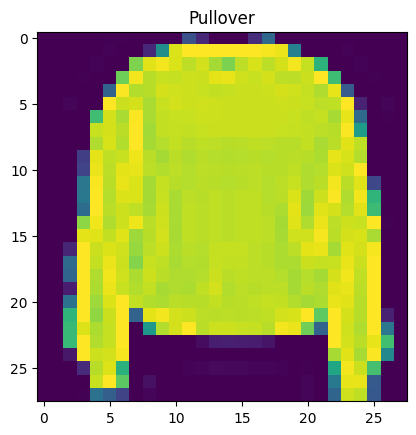

In [16]:
image, label = train_data[7]
plt.imshow(image.squeeze()); # squeeze para remover a dimensão externa [[[1,2,3]]] -> [[1,2,3]]
plt.title(class_names[label]);

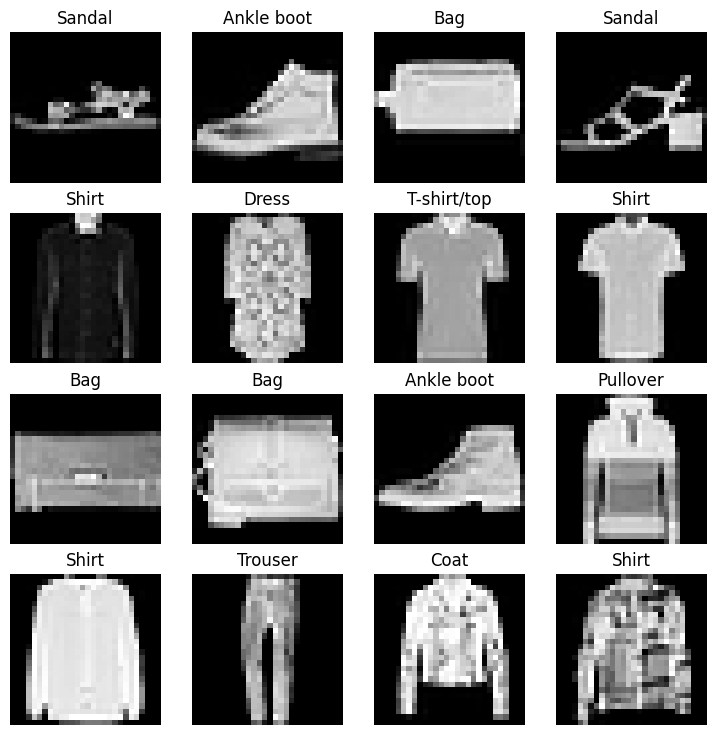

In [20]:
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

# 2. Carregar com Dataloader

In [21]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [25]:
# 1875 lotes com 32 imagens cada, totalizando 60000 imagens
len(train_dataloader), len(train_dataloader) * 32

(1875, 60000)

In [27]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [29]:
1*28*28

784

##### Seleciona uma imagem aleatória do batch atual (que possui 32 imagens (1,28,28))

(-0.5, 27.5, 27.5, -0.5)

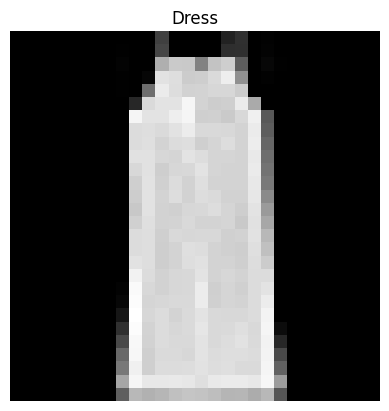

In [30]:
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()

img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off")

# 3 Construir o modelo

In [32]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x) # agora nosso vetor será: [1, 28, 28] -> [1, 784]
x. shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [33]:
from torch import nn

class FashionMnistModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # achatar nossa imagem: 784
            nn.Linear(input_shape, hidden_units),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [34]:
model_0 = FashionMnistModel(input_shape=784, # 784 + 10 / 2 = 392 nas hidden_units
                            hidden_units=256,
                            output_shape=len(class_names))

In [36]:
model_0.to("cpu")

FashionMnistModel(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

### Selecionar função de custo e otimizador

In [37]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    # Note: you need the "raw" GitHub URL for this to work
    request = requests.get("https://raw.githubusercontent.com/mafaldasalomao/pavic_treinamento_ml/main/utils/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

In [40]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss() # cost function
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1) # optimizer

# 4 Treinar o modelo

In [49]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start

    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [51]:
from tqdm.auto import tqdm

train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1} \n ---------------")

    train_loss = 0.
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        # 1 forward
        y_pred = model_0(X)
        # 2 calcular o loss
        loss = loss_fn(y_pred, y)
        train_loss += train_loss
        # 3 zero grad
        optimizer.zero_grad()
        # 4 loss backward
        loss.backward()
        # 5 step no otimizador
        optimizer.step()

        if batch % 400 == 0:
            print(f"O modelo viu {batch * len(X)} / {len(train_dataloader.dataset)} imagens")
    train_loss /= len(train_dataloader)

    ###TEST

    model_0.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)

            test_loss += loss_fn(test_pred, y)

            test_acc = accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    # print final para ver o que está ocorrendo
    print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}% \n")

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 
 ---------------
O modelo viu 0 / 60000 imagens
O modelo viu 12800 / 60000 imagens
O modelo viu 25600 / 60000 imagens
O modelo viu 38400 / 60000 imagens
O modelo viu 51200 / 60000 imagens
Train loss: 0.00000 | Test loss: 0.46673 | Test Acc: 0.28% 

Epoch: 2 
 ---------------
O modelo viu 0 / 60000 imagens
O modelo viu 12800 / 60000 imagens
O modelo viu 25600 / 60000 imagens
O modelo viu 38400 / 60000 imagens
O modelo viu 51200 / 60000 imagens
Train loss: 0.00000 | Test loss: 0.44980 | Test Acc: 0.24% 

Epoch: 3 
 ---------------
O modelo viu 0 / 60000 imagens
O modelo viu 12800 / 60000 imagens
O modelo viu 25600 / 60000 imagens
O modelo viu 38400 / 60000 imagens
O modelo viu 51200 / 60000 imagens
Train loss: 0.00000 | Test loss: 0.46230 | Test Acc: 0.28% 

Train time on cpu: 30.667 seconds


In [54]:
# função para testar o modelo
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc  += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc  /= len(data_loader)
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

In [55]:
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
                             loss_fn=loss_fn, accuracy_fn=accuracy_fn)

model_0_results

{'model_name': 'FashionMnistModel',
 'model_loss': 0.46230006217956543,
 'model_acc': 84.05551118210863}

# Replicar o experimento na GPU

## 1 Construir o modelo

In [57]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [56]:
from torch import nn

class FashionMnistModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # achatar nossa imagem: 784
            nn.Linear(input_shape, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [58]:
model_1 = FashionMnistModelV1(input_shape=784, # 784 + 10 / 2 = 392 nas hidden_units
                            hidden_units=256,
                            output_shape=len(class_names)).to(device)

In [60]:
# função de custo para mais de 2 classes
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

## 2 Treinar o novo modelo

In [69]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(data_loader):
        X, y, = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc  += accuracy_fn(y, y_pred.argmax(dim=1))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    train_acc  /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc  += accuracy_fn(y, test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")

In [70]:
train_time_start_on_gpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n ---------------")
    train_step(data_loader=train_dataloader,
               model=model_1,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn)
    test_step(data_loader=test_dataloader,
              model=model_1,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
 ---------------
Train loss: 0.55465 | Train accuracy: 80.08%
Test loss: 0.46302 | Test accuracy: 83.34%
Epoch: 1 
 ---------------
Train loss: 0.40108 | Train accuracy: 85.37%
Test loss: 0.43989 | Test accuracy: 83.88%
Epoch: 2 
 ---------------
Train loss: 0.35978 | Train accuracy: 86.89%
Test loss: 0.40656 | Test accuracy: 84.92%
Train time on cuda: 34.338 seconds
